In [1]:
# notebooks/01_eda.ipynb

# Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Load the Excel file
df = pd.read_excel("../data/raw/Online Retail.xlsx")
# Remove negative or zero quantities
df = df[df['Quantity'] > 0]
# Remove negative or zero unit prices
df = df[df['UnitPrice'] > 0]
# Convert CustomerID to string to treat it as categorical
df['CustomerID'] = df['CustomerID'].astype(str)
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   530104 non-null  object        
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.4+ MB


,Quantity,InvoiceDate,UnitPrice
count,530104.000000,530104,530104.000000
mean,10.542037,2011-07-04 20:16:05.225087744,3.907625
min,1.000000,2010-12-01 08:26:00,0.001000
25%,1.000000,2011-03-28 12:22:00,1.250000
50%,3.000000,2011-07-20 12:58:00,2.080000
75%,10.000000,2011-10-19 12:39:00,4.130000
max,80995.000000,2011-12-09 12:50:00,13541.330000
std,155.524124,NaN,35.915681


In [3]:
# Missing Values
missing = df.isnull().mean().sort_values(ascending=False)
if missing[missing > 0].sum() > 0:
    missing[missing > 0].plot(kind='barh', figsize=(8, 4), title="Missing Values Proportion")
else:
    print("No missing values found.")

No missing values found.


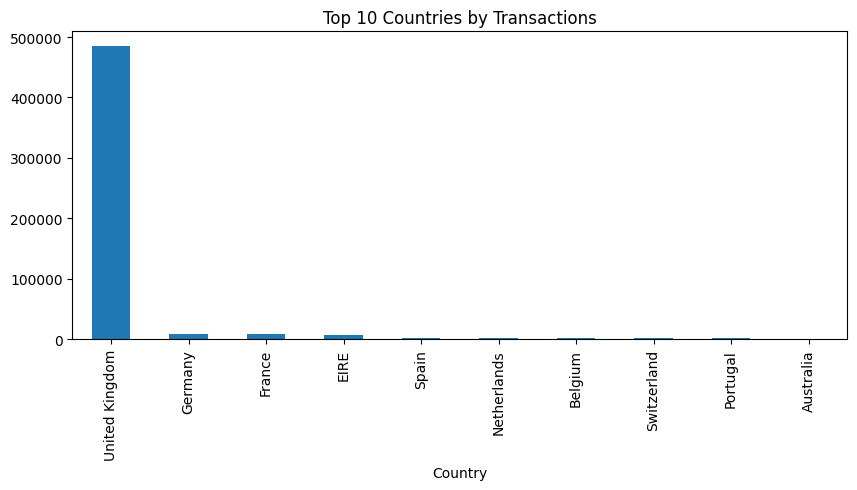

In [4]:
# Country Distribution
plt.figure(figsize=(10,4))
df['Country'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Top 10 Countries by Transactions")
plt.savefig("../results/visuals/Top 10 Countries by Transactions.png")

2010-12-01 08:26:00 2011-12-09 12:50:00


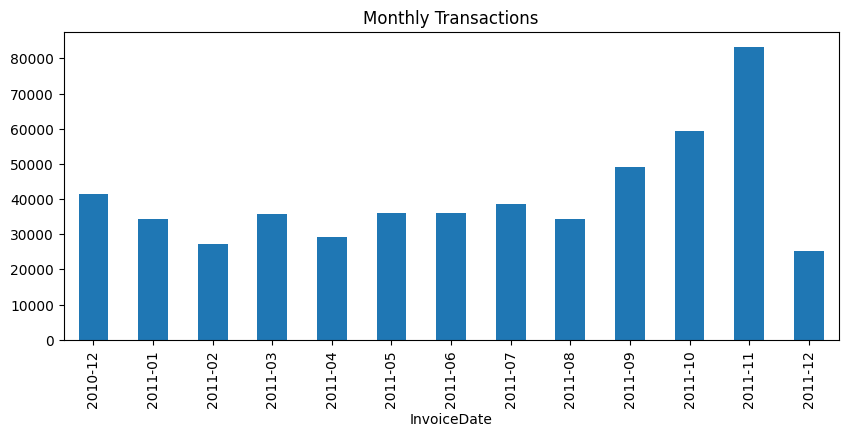

In [5]:
# Invoice Dates
print(df['InvoiceDate'].min(), df['InvoiceDate'].max())
df['InvoiceDate'].dt.to_period('M').value_counts().sort_index().plot(kind='bar', figsize=(10,4))
plt.title("Monthly Transactions")
plt.savefig("../results/visuals/Monthly Transactions.png")

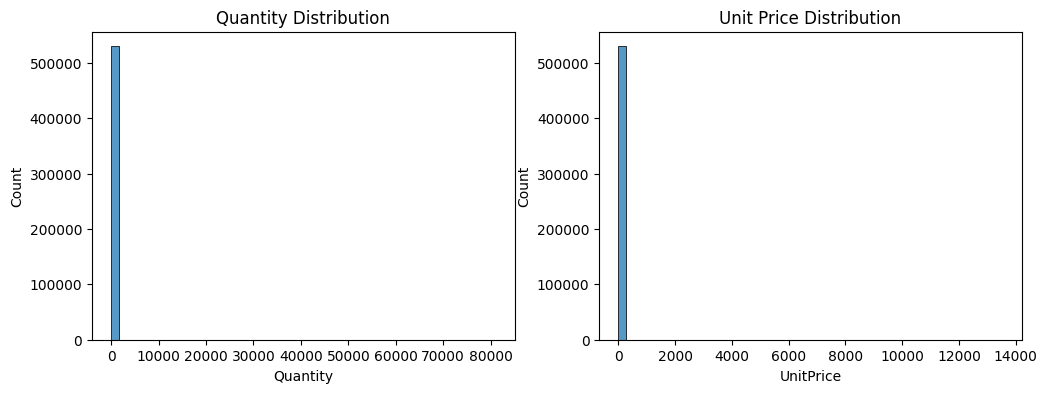

In [6]:
# Quantity & Unit Price Distribution
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['Quantity'], bins=50, ax=ax[0])
ax[0].set_title("Quantity Distribution")
sns.histplot(df['UnitPrice'], bins=50, ax=ax[1])
ax[1].set_title("Unit Price Distribution")
plt.savefig("../results/visuals/Quantity & Unit Price Distribution.png")

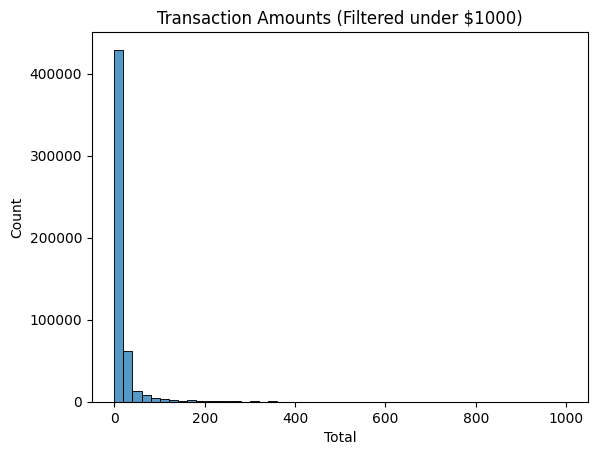

In [7]:
# Total Purchase Amount per Transaction
df['Total'] = df['Quantity'] * df['UnitPrice']
sns.histplot(df['Total'][df['Total'] < 1000], bins=50)
plt.title("Transaction Amounts (Filtered under $1000)")
plt.savefig("../results/visuals/Transaction Amounts (Filtered under $1000).png")

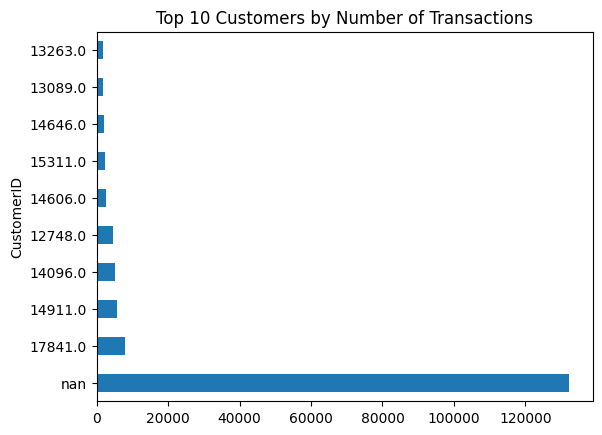

In [8]:
# Customers with Most Orders
top_customers = df['CustomerID'].value_counts().head(10)
top_customers.plot(kind='barh')
plt.title("Top 10 Customers by Number of Transactions")
plt.savefig("../results/visuals/Top 10 Customers by Number of Transactions.png")

In [9]:
# Calculate RFM (Recency, Frequency, Monetary)
# Ensure the 'InvoiceDate' is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Recency: Time since last purchase
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)  # The next day after the last transaction date
df_rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (unique invoices)
    'Total': 'sum'  # Monetary (sum of purchases)
}).reset_index()

# Rename columns to match RFM
df_rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Merge with the original dataset (if needed for further analysis)
df = pd.merge(df, df_rfm, on='CustomerID', how='left')
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Total', 'Recency', 'Frequency',
       'Monetary'],
      dtype='object')

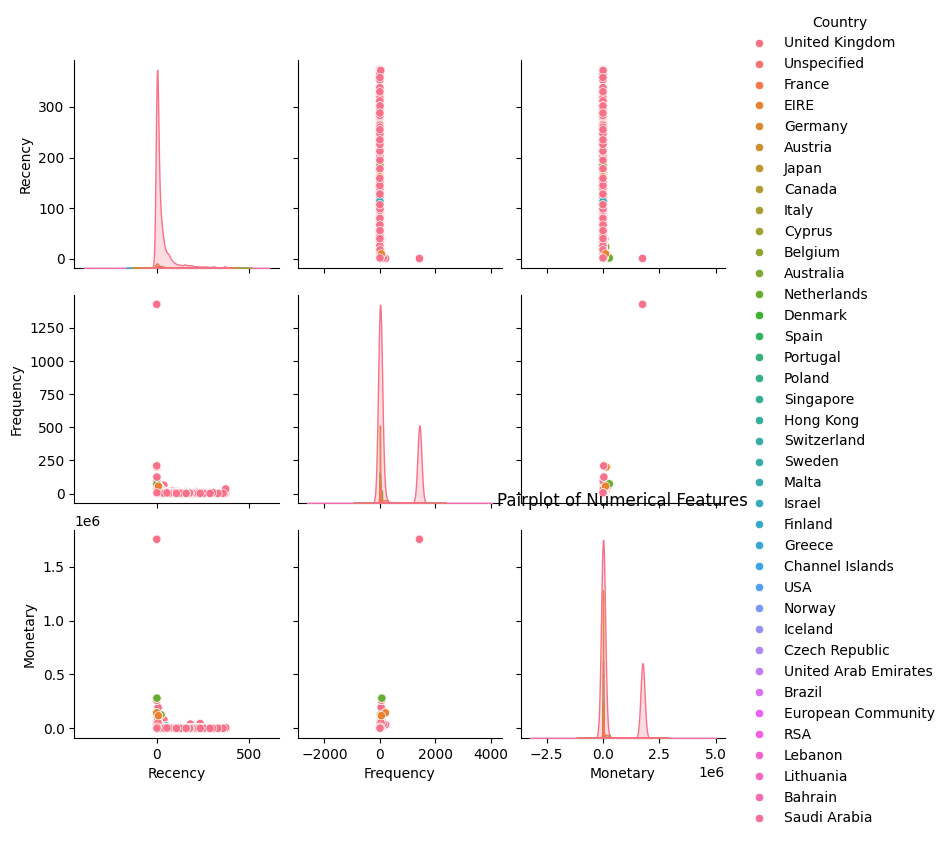

In [16]:
# Pairplot
# Selecting rfm features for the pairplot on a sample of the dataset due to computation time for pairplot
df_sample = df.sample(n=int(df.shape[0]*0.1), random_state=42)
rfm_features = ['Recency', 'Frequency', 'Monetary']
sns.pairplot(df_sample, vars=rfm_features, hue="Country", height=2.5)
plt.title("Pairplot of Numerical Features")
plt.savefig("../results/visuals/Pairplot of RFM Variables.png")

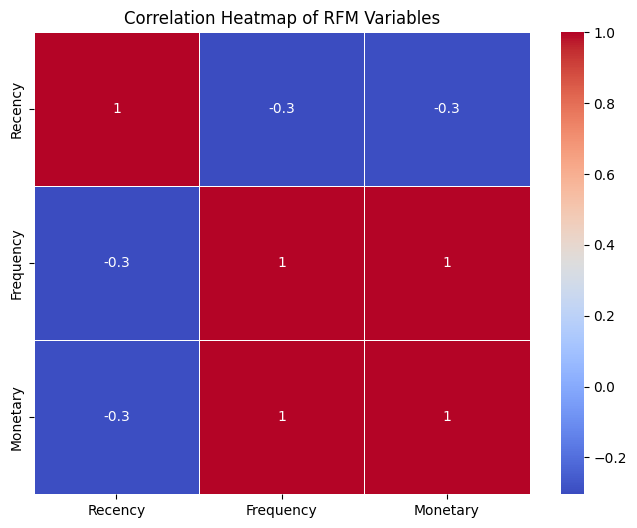

In [17]:
# Correlation Heatmap for RFM variables
corr_matrix = df[rfm_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of RFM Variables")
plt.savefig("../results/visuals/Correlation Heatmap of RFM Variables.png")

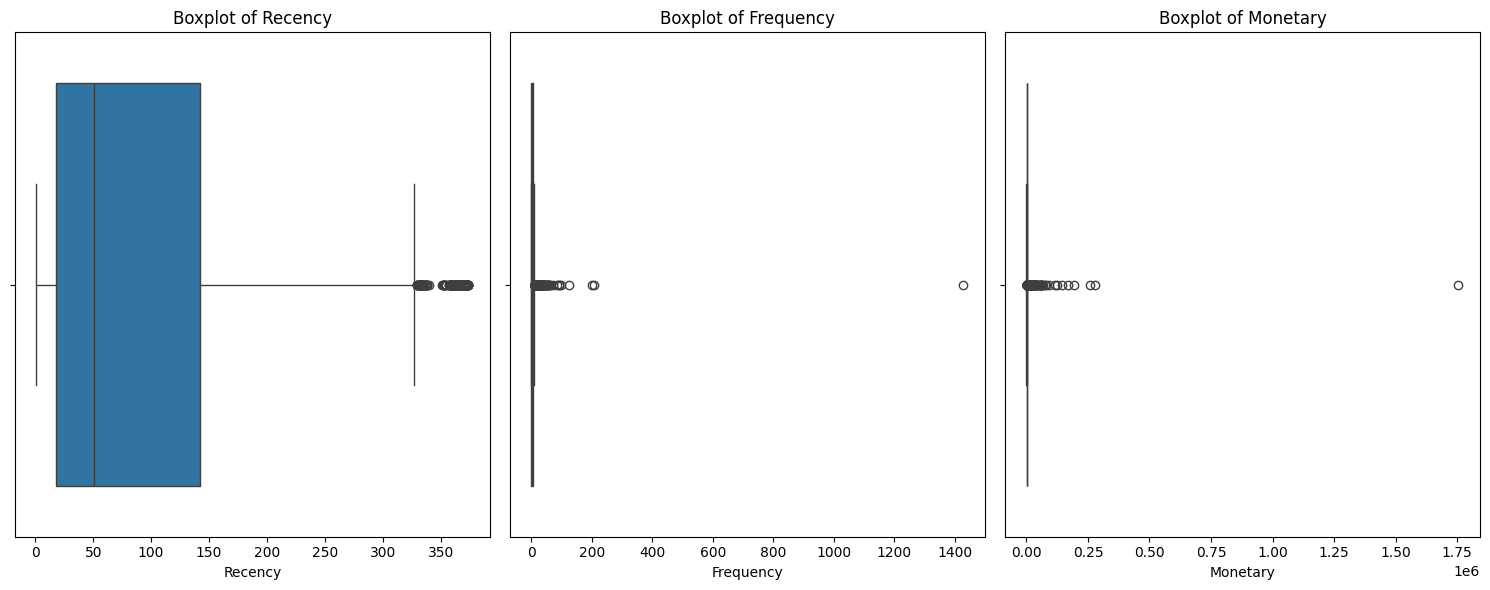

In [18]:
# Boxplots for Outlier Detection in RFM variables
plt.figure(figsize=(15, 6))
for i, feature in enumerate(rfm_features):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x=df_rfm[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.savefig("../results/visuals/Boxplots of RFM Variables.png")